In [1]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

from keras_ssd7 import build_model
from keras_ssd_loss import SSDLoss
from ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y, decode_y2
from ssd_batch_generator import BatchGenerator
from keras_layer_AnchorBoxes import AnchorBoxes
from keras_layer_L2Normalization import L2Normalization
def limit_mem():
    K.get_session().close()
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))
#limit_mem()

Using TensorFlow backend.


In [2]:
import shutil
import math
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        #ims = np.array((ims/2+0.5)*255).astype(np.uint8)
        ims = ims.astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % rows == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(str(titles[i]), fontsize=32)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [3]:
# only works in tf-1.3 docker, which python 2, in tf-1.3-py3 does not work
#% cd /host/workspace/corrections
#% run dlib_xml_to_ssd_csv.py testing.xml
#% run dlib_xml_to_ssd_csv.py training.xml
#% cd /host/workspace/ssd_keras

### 1. Introduction and building the model

The cell below sets a number of parameters that define the model architecture and then calls the function `build_model()` to build the model. Read the comments and the documentation, but here are some further explanations for a few parameters:

* Set the height, width, and number of color channels to whatever you want the model to accept as image input. This does not have to be the actual size of your input images! However, if your input images have a different size than you define as the model input here, you must use the `crop`, `resize` and/or `random_crop` features of the batch generator to convert your images to the model input size during training. If your dataset contains images of varying size, like the Pascal VOC datasets for example, use the `random_crop` feature of the batch generator to cope with that (see the documentation).
* The number of classes includes the background class, i.e. if you have `n` positive classes in your dataset, set `n_classes = n + 1`. Class ID 0 must always be reserved for the background class, i.e. your positive classes must have positive integers as IDs.
* The reason why the list of scaling factors has 5 elements even though there are only 4 predictor layers in this model is that the last scaling factor is used for the second aspect-ratio-1 box of the last predictor layer. See the documentation for details.
* Alternatively to passing an explicit list of scaling factors, you could also just define a mimimum and a maximum scale, in which case the other scaling factors would be linearly interpolated. If you pass both min/max scaling factors and an explicit list, the explicit list will be used.
* `build_model()` and `SSDBoxEncoder` have two arguments for the anchor box aspect ratios: `aspect_ratios_global` and `aspect_ratios_per_layer`. You can use either of the two. If you use `aspect_ratios_global`, then you just pass a list containing all aspect ratios for which you would like to create anchor boxes. Every aspect ratio you want to include must be listed once and only once. If you use `aspect_ratios_per_layer`, then you pass a list containing lists of aspect ratios for each individual predictor layer. In the example below, the model has four predictor layers, so you would pass a list containing four lists.
* If `two_boxes_for_ar1 == True`, then two boxes of different size will be created for aspect ratio 1 for each predictor layer. See the documentation for details.
* If `limit_boxes == True`, then the generated anchor boxes will be limited so that they lie entirely within the image boundaries. This feature is called 'clip' in the original Caffe implementation. Even though it may seem counterintuitive, it is recommended **not** to clip the anchor boxes. According to Wei Liu, the model performs slightly better when the anchors are not clipped.
* The variances are scaling factors for the target coordinates. Leaving them at 1.0 for each of the four box coordinates means that they have no effect whatsoever. Decreasing them to below 1.0 **upscales** the gradient for the respective target box coordinate.
* The `coords` argument lets you choose what coordinate format the model should learn. If you choose the 'centroids' format, the targets will be converted to the (cx, cy, w, h) coordinate format used in the original implementation. If you choose the 'minmax' format, the targets will be converted to the coordinate format (xmin, xmax, ymin, ymax). The model, of course, will learn whatever the targets tell it to.
* `normalize_coords` converts all absolute ground truth and anchor box coordinates to relative coordinates, i.e. to coordinates that lie within [0,1] relative to the image height and width. Whether you use absolute or relative coordinates has no effect on the training - the targets end up being the same in both cases. The main reason why the original implementation uses relative coordinates is because it makes coding some box operations more convenient. This defaults to `False`.

These paramters might be a bit much at first, but they allow you to configure many things easily.

The parameters set below are not only needed to build the model, but are also passed to the `SSDBoxEncoder` constructor in the subsequent cell, which is responsible for matching and encoding ground truth boxes and anchor boxes during training. In order to do that, it needs to know the anchor box specifications. It is for the same reason that `build_model()` does not only return the model itself, but also `predictor_sizes`, a list of the spatial sizes of the convolutional predictor layers - `SSDBoxEncoder` needs this information to know where the anchor boxes must be placed spatially.

The original Caffe implementation does pretty much everything inside a model layer: The ground truth boxes are matched and encoded inside [MultiBoxLossLayer](https://github.com/weiliu89/caffe/blob/ssd/src/caffe/layers/multibox_loss_layer.cpp), and box decoding, confidence thresholding and non-maximum suppression is performed in [DetectionOutputLayer](https://github.com/weiliu89/caffe/blob/ssd/src/caffe/layers/detection_output_layer.cpp). In contrast to that, in the current form of this implementation, ground truth box matching and encoding happens as part of the mini batch generation (i.e. outside of the model itself). To be specific, the `generate()` method of `BatchGenerator` calls the `encode_y()` method of `SSDBoxEncoder` to encode the ground truth labels, and then yields the matched and encoded target tensor to be passed to the loss function. Similarly, the model here outputs the raw prediction tensor. The decoding, confidence thresholding, and non-maximum suppression (NMS) is then performed by `decode_y2()`, i.e. also outside the model. It's (almost) the same process as in the original Caffe implmentation, it's just that the code is organized differently here, which likely has performance implications, but I haven't measured it yet. I might look into incorporating all processing steps inside the model itself, but for now it was just easier to take the non-learning-relevant steps outside of Keras/Tensorflow. This is one advantage of Caffe: It's more convenient to write complex custom layers in plain C++ than to grapple with the Keras/Tensorflow API.

### Note:

The example setup below was used to train SSD7 on two street traffic datasets released by [Udacity](https://github.com/udacity/self-driving-car/tree/master/annotations) with around 20,000 images in total and 5 object classes (car, truck, pedestrian, bicyclist, traffic light), although the vast majority of the objects are cars. The original datasets have a constant image size of 1200x1920 RGB. I consolidated the two datasets, removed a few bad samples (although there are probably many more), and resized the images to 300x480 RGB, i.e. to one sixteenth of the original image size. In case you'd like to train a model on the same dataset, you can find the consolidated and resized dataset I used [here](https://drive.google.com/file/d/0B0WbA4IemlxlT1IzQ0U1S2xHYVU/view?usp=sharing).

In [4]:
### Set up the model

# 1: Set some necessary parameters

img_height = 300 # Height of the input images
img_width = 256 # Width of the input images
img_channels = 3 # Number of color channels of the input images
n_classes = 2 # Number of classes including the background class
min_scale = 0.1 # The scaling factor for the smallest anchor boxes
max_scale = 0.6 # The scaling factor for the largest anchor boxes
scales = None # An explicit list of anchor box scaling factors. If this is passed, it will override `min_scale` and `max_scale`.
aspect_ratios = [0.5, 1.0, 2.0, 3.0] # The list of aspect ratios for the anchor boxes
two_boxes_for_ar1 = True # Whether or not you want to generate two anchor boxes for aspect ratio 1
limit_boxes = False # Whether or not you want to limit the anchor boxes to lie entirely within the image boundaries
variances = [1.0, 1.0, 1.0, 1.0] # The list of variances by which the encoded target coordinates are scaled
coords = 'centroids' # Whether the box coordinates to be used should be in the 'centroids' or 'minmax' format, see documentation
normalize_coords = False # Whether or not the model is supposed to use relative coordinates that are within [0,1]

# 2: Build the Keras model (and possibly load some trained weights)

K.clear_session() # Clear previous models from memory.
# The output `predictor_sizes` is needed below to set up `SSDBoxEncoder`
model, predictor_sizes = build_model(image_size=(img_height, img_width, img_channels),
                                     n_classes=n_classes,
                                     min_scale=min_scale,
                                     max_scale=max_scale,
                                     scales=scales,
                                     aspect_ratios_global=aspect_ratios,
                                     aspect_ratios_per_layer=None,
                                     two_boxes_for_ar1=two_boxes_for_ar1,
                                     limit_boxes=limit_boxes,
                                     variances=variances,
                                     coords=coords,
                                     normalize_coords=normalize_coords)
#model.load_weights('./ssd7_0_weights.h5')
#model = load_model('./ssd7_0.h5')

### 2. Set up the training

The cell below sets up everything necessary to train the model. The only things you have to set are the correct file paths to the images and labels in your dataset, and in case your labels do not come in a CSV file, you might have to switch from the CSV parser to the XML parser or you might have to write a new parser method in the `BatchGenerator` class that can handle whatever the format of your labels is. The README of this project provides an overview of the design of the batch generator class, which should help you in case you need to write a new parser or adapt one of the existing parsers to your needs.

For everything in this cell that does not concern loading your data: You don't have to change anything (but you can change everything of course).

Set the batch size to whatever value you like (and one that makes the model fit inside your GPU memory), it's not the most important hyperparameter - 32 works well, but so do most other batch sizes.

I'm using an Adam optimizer with the standard initial learning rate of 0.001 and a small decay, nothing special.

`SSDLoss` is a custom Keras loss function that implements the multi-task log loss for classification and smooth L1 loss for localization. `neg_pos_ratio` and `alpha` are set as in the paper and `n_neg_min` is a rather unimportant optional parameter to make sure that a certain number of negative boxes always enters the loss function even if there are very few or no positive boxes in a batch, which should never happen anyway.

The `ssd_box_encoder` object, which, as explained above, knows how to match and encode the ground truth labels into the format that the model needs, is passed to the batch generator, which during training loads the next batch of images and labels, optionally performs data augmentation, and encodes the ground truth labels.

There are two parameters in the SSDBoxEncoder that you should note: `pos_iou_threshold` and `neg_iou_threshold`. The former determines the minimum Jaccard overlap between a ground truth box and an anchor box for a match and is set to 0.5, the value stated in the paper. The latter, `neg_iou_threshold`, is not in the paper, but it is useful to improve the learning process. It determines the maximum allowed Jaccard overlap between an anchor box and any ground truth box in order for that anchor box to be considered a negative box. This is useful because you want a clear margin between negative and positive boxes. An anchor box that almost contains an object should not be forced to learn to predict a negative box in such a case. 0.2 is a reasonable value that is used by various other object detection models.

In [3]:
batch_size = 32
# Training dataset
train_images_path = '../corrections/sheets/resized/'
train_labels_path = '../corrections/training.csv'

# Validation dataset
val_images_path = '../corrections/sheets/resized/'
val_labels_path = '../corrections/testing.csv'

train_dataset = BatchGenerator(box_output_format=['class_id', 'xmin', 'xmax', 'ymin', 'ymax']) # This is the format in which the generator is supposed to output the labels. At the moment it **must** be the format set here.

train_dataset.parse_csv(images_path=train_images_path,
                        labels_path=train_labels_path,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                        include_classes='all')

n_train_samples = train_dataset.get_n_samples()

# 6: Create the validation set batch generator (if you want to use a validation dataset)

val_dataset = BatchGenerator(box_output_format=['class_id', 'xmin', 'xmax', 'ymin', 'ymax'])

val_dataset.parse_csv(images_path=val_images_path,
                      labels_path=val_labels_path,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')

n_val_samples = val_dataset.get_n_samples()


In [5]:
### Set up training


# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=5e-05)

ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

# 4: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function 

ssd_box_encoder = SSDBoxEncoder(img_height=img_height,
                                img_width=img_width,
                                n_classes=n_classes, 
                                predictor_sizes=predictor_sizes,
                                min_scale=min_scale,
                                max_scale=max_scale,
                                scales=scales,
                                aspect_ratios_global=aspect_ratios,
                                aspect_ratios_per_layer=None,
                                two_boxes_for_ar1=two_boxes_for_ar1,
                                limit_boxes=limit_boxes,
                                variances=variances,
                                pos_iou_threshold=0.6,
                                neg_iot_threshold=0.3,
                                coords=coords,
                                normalize_coords=normalize_coords)

# 5: Create the training set batch generator

# TODO: Set the paths to your datasets here.


# Change the online data augmentation settings as you like
train_generator = train_dataset.generate(batch_size=batch_size,
                                         train=True,
                                         ssd_box_encoder=ssd_box_encoder,
                                         equalize=False,
                                         brightness=(0.5, 2, 0.5), # Randomly change brightness between 0.5 and 2 with probability 0.5
                                         flip=False, # Randomly flip horizontally with probability 0.5
                                         translate=False, #((5, 50), (3, 30), 0.5), # Randomly translate by 5-50 pixels horizontally and 3-30 pixels vertically with probability 0.5
                                         scale=False, #(0.75, 1.3, 0.5), # Randomly scale between 0.75 and 1.3 with probability 0.5
                                         max_crop_and_resize=False,
                                         full_crop_and_resize=False,
                                         random_crop=(img_height, img_width, 1, 20),
                                         crop=False,
                                         resize=False,
                                         gray=False,
                                         limit_boxes=True,
                                         include_thresh=0.4,
                                         diagnostics=False)


val_generator = val_dataset.generate(batch_size=batch_size,
                                     train=True,
                                     ssd_box_encoder=ssd_box_encoder,
                                     equalize=False,
                                     brightness=False,
                                     flip=False,
                                     translate=False,
                                     scale=False,
                                     max_crop_and_resize=False,
                                     full_crop_and_resize=False,
                                     random_crop=(img_height, img_width, 1, 20),
                                     crop=False,
                                     resize=False,
                                     gray=False,
                                     limit_boxes=True,
                                     include_thresh=0.4,
                                     diagnostics=False)



### 3. Run the training

Now that everything is set up, we're ready to start training. Set the number of epochs and the model name, the weights name in `ModelCheckpoint` and the filepaths to wherever you'd like to save the model. There isn't much more to say here, just execute the cell. If you get "out of memory" errors during training, reduce the batch size.

Training currently only monitors the validation loss, not the mAP.

In [47]:
### Run training

# 6: Run training

epochs = 10
model.optimizer = Adam(lr=0.00005)
history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = ceil(n_train_samples/batch_size),
                              epochs = epochs,
                              callbacks = [
                                  ModelCheckpoint('../corrections/ssd7_0_weights_epoch{epoch:02d}_loss{loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1),
                                           #EarlyStopping(monitor='val_loss',
                                           #              min_delta=0.001,
                                           #              patience=2),
                                           ReduceLROnPlateau(monitor='val_loss',
                                                             factor=0.8,
                                                             patience=5,
                                                             epsilon=0.001,
                                                             verbose=1,
                                                             cooldown=10)],
                              validation_data = val_generator,
                              validation_steps = ceil(n_val_samples/batch_size))



Epoch 1/10
19/19 [==============================] - 21s - loss: 0.0781 - val_loss: 0.1534
Epoch 2/10
19/19 [==============================] - 20s - loss: 0.0792 - val_loss: 0.1318
Epoch 3/10
19/19 [==============================] - 20s - loss: 0.0771 - val_loss: 0.1315
Epoch 4/10
19/19 [==============================] - 19s - loss: 0.0786 - val_loss: 0.1358
Epoch 5/10
19/19 [==============================] - 20s - loss: 0.0779 - val_loss: 0.1447
Epoch 6/10
19/19 [==============================] - 19s - loss: 0.0805 - val_loss: 0.1300
Epoch 7/10
19/19 [==============================] - 20s - loss: 0.0815 - val_loss: 0.1467
Epoch 8/10
19/19 [==============================] - 19s - loss: 0.0787 - val_loss: 0.1512
Epoch 9/10
19/19 [==============================] - 21s - loss: 0.0808 - val_loss: 0.1409
Epoch 10/10
19/19 [==============================] - 20s - loss: 0.0799 - val_loss: 0.1380


In [73]:
model_name = 'ssd7_0'
model.save('../corrections/{}.h5'.format(model_name))
model.save_weights('../corrections/{}_weights.h5'.format(model_name))

print()
print("Model saved as {}.h5".format(model_name))
print("Weights also saved separately as {}_weights.h5".format(model_name))
print()


Model saved as ssd7_0.h5
Weights also saved separately as ssd7_0_weights.h5



## more augmentation

In [6]:
import keras
model.load_weights('../corrections/ssd7_0_weights.h5')

In [7]:
# Change the online data augmentation settings as you like
train_generator = train_dataset.generate(batch_size=batch_size,
                                         train=True,
                                         ssd_box_encoder=ssd_box_encoder,
                                         equalize=False,
                                         brightness=(0.5, 2, 0.5), # Randomly change brightness between 0.5 and 2 with probability 0.5
                                         flip=False, # Randomly flip horizontally with probability 0.5
                                         translate=False, #((5, 50), (3, 30), 0.5), # Randomly translate by 5-50 pixels horizontally and 3-30 pixels vertically with probability 0.5
                                         scale=(0.75, 1.3, 0.5), # Randomly scale between 0.75 and 1.3 with probability 0.5
                                         max_crop_and_resize=False,
                                         full_crop_and_resize=False,
                                         random_crop=(img_height, img_width, 1, 20),
                                         crop=False,
                                         resize=False,
                                         gray=False,
                                         limit_boxes=True,
                                         include_thresh=0.8,
                                         diagnostics=False)

n_train_samples = train_dataset.get_n_samples()



In [8]:
epochs = 100
model.optimizer = Adam(lr=0.0001)
model_name = 'ssd7_1'
history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = ceil(n_train_samples/batch_size),
                              epochs = epochs,
                              callbacks = [
                                  ModelCheckpoint('../corrections/ssd7_1_weights_epoch{epoch:02d}_loss{loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1),
                                           #EarlyStopping(monitor='val_loss',
                                           #              min_delta=0.001,
                                           #              patience=2),
                                           ReduceLROnPlateau(monitor='val_loss',
                                                             factor=0.8,
                                                             patience=5,
                                                             epsilon=0.001,
                                                             verbose=1,
                                                             cooldown=10)],
                              validation_data = val_generator,
                              validation_steps = ceil(n_val_samples/batch_size))


Epoch 1/100
19/19 [==============================] - 25s - loss: 0.0842 - val_loss: 0.1349
Epoch 2/100
19/19 [==============================] - 18s - loss: 0.0787 - val_loss: 0.1353
Epoch 3/100
19/19 [==============================] - 21s - loss: 0.0857 - val_loss: 0.1227
Epoch 4/100
19/19 [==============================] - 19s - loss: 0.0822 - val_loss: 0.1371
Epoch 5/100
19/19 [==============================] - 22s - loss: 0.0820 - val_loss: 0.1448
Epoch 6/100
19/19 [==============================] - 19s - loss: 0.0821 - val_loss: 0.1389
Epoch 7/100
19/19 [==============================] - 21s - loss: 0.0807 - val_loss: 0.1232
Epoch 8/100
19/19 [==============================] - 19s - loss: 0.0787 - val_loss: 0.1427
Epoch 9/100
18/19 [===========================>..] - ETA: 1s - loss: 0.0776Epoch 00008: val_loss did not improve

Epoch 00008: reducing learning rate to 7.999999797903001e-05.
19/19 [==============================] - 21s - loss: 0.0798 - val_loss: 0.1237
Epoch 10/100
19/1

19/19 [==============================] - 19s - loss: 0.0759 - val_loss: 0.1253
Epoch 82/100
19/19 [==============================] - 21s - loss: 0.0792 - val_loss: 0.1522
Epoch 83/100
19/19 [==============================] - 20s - loss: 0.0770 - val_loss: 0.1175
Epoch 84/100
19/19 [==============================] - 19s - loss: 0.0753 - val_loss: 0.1071
Epoch 85/100
19/19 [==============================] - 20s - loss: 0.0772 - val_loss: 0.1304
Epoch 86/100
19/19 [==============================] - 19s - loss: 0.0774 - val_loss: 0.1413
Epoch 87/100
19/19 [==============================] - 21s - loss: 0.0772 - val_loss: 0.1216
Epoch 88/100
18/19 [===========================>..] - ETA: 0s - loss: 0.0776Epoch 00087: val_loss did not improve

Epoch 00087: reducing learning rate to 2.6214399258606137e-05.
19/19 [==============================] - 19s - loss: 0.0782 - val_loss: 0.1247
Epoch 89/100
19/19 [==============================] - 21s - loss: 0.0774 - val_loss: 0.1299
Epoch 90/100
19/19 [

In [10]:
model.load_weights('../corrections/ssd7_1_weights_epoch49_loss0.0769.h5')

In [11]:
model_name = 'ssd7_1'
model.save('../corrections/{}.h5'.format(model_name))
model.save_weights('../corrections/{}_weights.h5'.format(model_name))

In [12]:
 K.get_value(model.optimizer.lr)

2.6214399e-05

## reduce image size again

In [47]:

img_height = 192 # Height of the input images
img_width = 192 # Width of the input images
img_channels = 3 # Number of color channels of the input images
n_classes = 2 # Number of classes including the background class
min_scale = 0.1 # The scaling factor for the smallest anchor boxes
max_scale = 0.6 # The scaling factor for the largest anchor boxes
scales = None # An explicit list of anchor box scaling factors. If this is passed, it will override `min_scale` and `max_scale`.
aspect_ratios = [0.5, 1.0, 2.0, 3.0] # The list of aspect ratios for the anchor boxes
two_boxes_for_ar1 = True # Whether or not you want to generate two anchor boxes for aspect ratio 1
limit_boxes = False # Whether or not you want to limit the anchor boxes to lie entirely within the image boundaries
variances = [1.0, 1.0, 1.0, 1.0] # The list of variances by which the encoded target coordinates are scaled
coords = 'centroids' # Whether the box coordinates to be used should be in the 'centroids' or 'minmax' format, see documentation
normalize_coords = False # Whether or not the model is supposed to use relative coordinates that are within [0,1]

# 2: Build the Keras model (and possibly load some trained weights)

K.clear_session() # Clear previous models from memory.
# The output `predictor_sizes` is needed below to set up `SSDBoxEncoder`
model, predictor_sizes = build_model(image_size=(img_height, img_width, img_channels),
                                     n_classes=n_classes,
                                     min_scale=min_scale,
                                     max_scale=max_scale,
                                     scales=scales,
                                     aspect_ratios_global=aspect_ratios,
                                     aspect_ratios_per_layer=None,
                                     two_boxes_for_ar1=two_boxes_for_ar1,
                                     limit_boxes=limit_boxes,
                                     variances=variances,
                                     coords=coords,
                                     normalize_coords=normalize_coords)
model.load_weights('../corrections/ssd7_1_weights.h5')
#model = load_model('./ssd7_0.h5')

### Set up training
batch_size = 32

# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=5e-05)

ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

# 4: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function 

ssd_box_encoder = SSDBoxEncoder(img_height=img_height,
                                img_width=img_width,
                                n_classes=n_classes, 
                                predictor_sizes=predictor_sizes,
                                min_scale=min_scale,
                                max_scale=max_scale,
                                scales=scales,
                                aspect_ratios_global=aspect_ratios,
                                aspect_ratios_per_layer=None,
                                two_boxes_for_ar1=two_boxes_for_ar1,
                                limit_boxes=limit_boxes,
                                variances=variances,
                                pos_iou_threshold=0.6,
                                neg_iot_threshold=0.3,
                                coords=coords,
                                normalize_coords=normalize_coords)

# 5: Create the training set batch generator

# TODO: Set the paths to your datasets here.

# Training dataset
train_images_path = '../corrections/sheets/resized/'
train_labels_path = '../corrections/training.csv'

# Validation dataset
val_images_path = '../corrections/sheets/resized/'
val_labels_path = '../corrections/testing.csv'

train_dataset = BatchGenerator(box_output_format=['class_id', 'xmin', 'xmax', 'ymin', 'ymax']) # This is the format in which the generator is supposed to output the labels. At the moment it **must** be the format set here.

train_dataset.parse_csv(images_path=train_images_path,
                        labels_path=train_labels_path,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                        include_classes='all')

# 6: Create the validation set batch generator (if you want to use a validation dataset)

val_dataset = BatchGenerator(box_output_format=['class_id', 'xmin', 'xmax', 'ymin', 'ymax'])

val_dataset.parse_csv(images_path=val_images_path,
                      labels_path=val_labels_path,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')

val_generator = val_dataset.generate(batch_size=batch_size,
                                     train=True,
                                     ssd_box_encoder=ssd_box_encoder,
                                     equalize=False,
                                     brightness=False,
                                     flip=False,
                                     translate=False,
                                     scale=False,
                                     max_crop_and_resize=False,
                                     full_crop_and_resize=False,
                                     random_crop=(img_height, img_width, 1, 20),
                                     crop=False,
                                     resize=False,
                                     gray=False,
                                     limit_boxes=True,
                                     include_thresh=0.8,
                                     diagnostics=False)

n_val_samples = val_dataset.get_n_samples()

# Change the online data augmentation settings as you like
train_generator = train_dataset.generate(batch_size=batch_size,
                                         train=True,
                                         ssd_box_encoder=ssd_box_encoder,
                                         equalize=False,
                                         brightness=(0.5, 2, 0.5), # Randomly change brightness between 0.5 and 2 with probability 0.5
                                         flip=False, # Randomly flip horizontally with probability 0.5
                                         translate=False, #((5, 50), (3, 30), 0.5), # Randomly translate by 5-50 pixels horizontally and 3-30 pixels vertically with probability 0.5
                                         scale=(0.75, 1, 0.5), # Randomly scale between 0.75 and 1.3 with probability 0.5
                                         max_crop_and_resize=False,
                                         full_crop_and_resize=False,
                                         random_crop=(img_height, img_width, 1, 20),
                                         crop=False,
                                         resize=False,
                                         gray=False,
                                         limit_boxes=True,
                                         include_thresh=0.8,
                                         diagnostics=False)

n_train_samples = train_dataset.get_n_samples()


In [48]:
epochs = 100
model.optimizer = Adam(lr=0.0001)
model_name = 'ssd7_2'
history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = ceil(n_train_samples/batch_size),
                              epochs = epochs,
                              callbacks = [
                                  ModelCheckpoint('../corrections/ssd7_2_weights_epoch{epoch:02d}_loss{loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1),
                                           #EarlyStopping(monitor='val_loss',
                                           #              min_delta=0.001,
                                           #              patience=2),
                                           ReduceLROnPlateau(monitor='val_loss',
                                                             factor=0.8,
                                                             patience=5,
                                                             epsilon=0.001,
                                                             verbose=1,
                                                             cooldown=10)],
                              validation_data = val_generator,
                              validation_steps = ceil(n_val_samples/batch_size))


Epoch 1/100
19/19 [==============================] - 22s - loss: 0.1208 - val_loss: 0.1589
Epoch 2/100
19/19 [==============================] - 17s - loss: 0.1099 - val_loss: 0.1446
Epoch 3/100
19/19 [==============================] - 19s - loss: 0.1123 - val_loss: 0.1541
Epoch 4/100
19/19 [==============================] - 17s - loss: 0.1044 - val_loss: 0.1942
Epoch 5/100
19/19 [==============================] - 19s - loss: 0.1098 - val_loss: 0.1867
Epoch 6/100
19/19 [==============================] - 17s - loss: 0.1049 - val_loss: 0.1976
Epoch 7/100
19/19 [==============================] - 18s - loss: 0.1040 - val_loss: 0.1697
Epoch 8/100
18/19 [===========================>..] - ETA: 0s - loss: 0.1042Epoch 00007: val_loss did not improve

Epoch 00007: reducing learning rate to 7.999999797903001e-05.
19/19 [==============================] - 17s - loss: 0.1054 - val_loss: 0.1783
Epoch 9/100
19/19 [==============================] - 18s - loss: 0.1055 - val_loss: 0.1785
Epoch 10/100
19/1

19/19 [==============================] - 17s - loss: 0.1051 - val_loss: 0.1781
Epoch 83/100
19/19 [==============================] - 18s - loss: 0.0984 - val_loss: 0.1606
Epoch 84/100
19/19 [==============================] - 17s - loss: 0.0979 - val_loss: 0.1293
Epoch 85/100
19/19 [==============================] - 18s - loss: 0.1003 - val_loss: 0.1575
Epoch 86/100
18/19 [===========================>..] - ETA: 0s - loss: 0.1016Epoch 00085: val_loss did not improve

Epoch 00085: reducing learning rate to 2.6214399258606137e-05.
19/19 [==============================] - 17s - loss: 0.1029 - val_loss: 0.2002
Epoch 87/100
19/19 [==============================] - 18s - loss: 0.1015 - val_loss: 0.1985
Epoch 88/100
19/19 [==============================] - 17s - loss: 0.1082 - val_loss: 0.1698
Epoch 89/100
19/19 [==============================] - 18s - loss: 0.0986 - val_loss: 0.1689
Epoch 90/100
19/19 [==============================] - 17s - loss: 0.0978 - val_loss: 0.1573
Epoch 91/100
19/19 [

In [49]:
model.load_weights('../corrections/ssd7_2_weights_epoch34_loss0.1001.h5')

In [50]:
model_name = 'ssd7_2'
model.save('../corrections/{}.h5'.format(model_name))
model.save_weights('../corrections/{}_weights.h5'.format(model_name))

# train using math5000

In [108]:
aspect_ratios = [0.5, 1.0, 2.0, 3.0] # The list of aspect ratios for the anchor boxes
pos_iou_threshold=0.6
neg_iot_threshold=0.1
testing_iou_threshold=0.01
include_thresh = 0.8
model_name = 'ssd7_7'
model_file_pattern = '../../data/corrections/ssd7_7_weights_epoch{epoch:02d}_loss{loss:.4f}.h5'
batch_size = 16

#img_height = 300 # Height of the input images
#img_width = 256 # Width of the input images
#min_scale = 0.1 # The scaling factor for the smallest anchor boxes
#max_scale = 0.6 # The scaling factor for the largest anchor boxes
#aug_scale=(0.75, 1, 0.5)
#aug_brightness=(0.5, 2, 0.5)

img_height = 850#640 # Height of the input images
img_width = 640 # Width of the input images
min_scale = 0.02 # The scaling factor for the smallest anchor boxes
max_scale = 0.4 # The scaling factor for the largest anchor boxes
aug_scale=False
aug_brightness=(0.8, 1.2, 0.5)

img_channels = 3 # Number of color channels of the input images
n_classes = 2 # Number of classes including the background class
scales = None # An explicit list of anchor box scaling factors. If this is passed, it will override `min_scale` and `max_scale`.
two_boxes_for_ar1 = True # Whether or not you want to generate two anchor boxes for aspect ratio 1
limit_boxes = False # Whether or not you want to limit the anchor boxes to lie entirely within the image boundaries
variances = [1.0, 1.0, 1.0, 1.0] # The list of variances by which the encoded target coordinates are scaled
coords = 'centroids' # Whether the box coordinates to be used should be in the 'centroids' or 'minmax' format, see documentation
normalize_coords = False # Whether or not the model is supposed to use relative coordinates that are within [0,1]


# 2: Build the Keras model (and possibly load some trained weights)

K.clear_session() # Clear previous models from memory.
# The output `predictor_sizes` is needed below to set up `SSDBoxEncoder`
model, predictor_sizes = build_model(image_size=(img_height, img_width, img_channels),
                                     n_classes=n_classes,
                                     min_scale=min_scale,
                                     max_scale=max_scale,
                                     scales=scales,
                                     aspect_ratios_global=aspect_ratios,
                                     aspect_ratios_per_layer=None,
                                     two_boxes_for_ar1=two_boxes_for_ar1,
                                     limit_boxes=limit_boxes,
                                     variances=variances,
                                     coords=coords,
                                     normalize_coords=normalize_coords)
model.load_weights('../../data/corrections/ssd7_6_weights.h5')
#model = load_model('./ssd7_0.h5')

### Set up training

# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=5e-05)

ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

# 4: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function 

ssd_box_encoder = SSDBoxEncoder(img_height=img_height,
                                img_width=img_width,
                                n_classes=n_classes, 
                                predictor_sizes=predictor_sizes,
                                min_scale=min_scale,
                                max_scale=max_scale,
                                scales=scales,
                                aspect_ratios_global=aspect_ratios,
                                aspect_ratios_per_layer=None,
                                two_boxes_for_ar1=two_boxes_for_ar1,
                                limit_boxes=limit_boxes,
                                variances=variances,
                                pos_iou_threshold=pos_iou_threshold,
                                neg_iot_threshold=neg_iot_threshold,
                                coords=coords,
                                normalize_coords=normalize_coords)

# 5: Create the training set batch generator

# TODO: Set the paths to your datasets here.

# Training dataset
train_images_path = '../../data/corrections/set2/sheetimages/'
train_labels_path = '../../data/corrections/math5000_training.csv'

# Validation dataset
val_images_path = '../../data/corrections/set2/sheetimages/'
val_labels_path = '../../data/corrections/math5000_testing.csv'

train_dataset = BatchGenerator(box_output_format=['class_id', 'xmin', 'xmax', 'ymin', 'ymax']) # This is the format in which the generator is supposed to output the labels. At the moment it **must** be the format set here.

train_dataset.parse_csv(images_path=train_images_path,
                        labels_path=train_labels_path,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                        include_classes='all')

# 6: Create the validation set batch generator (if you want to use a validation dataset)

val_dataset = BatchGenerator(box_output_format=['class_id', 'xmin', 'xmax', 'ymin', 'ymax'])

val_dataset.parse_csv(images_path=val_images_path,
                      labels_path=val_labels_path,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')

val_generator = val_dataset.generate(batch_size=batch_size,
                                     train=True,
                                     ssd_box_encoder=ssd_box_encoder,
                                     equalize=False,
                                     brightness=False,
                                     flip=False,
                                     translate=False,
                                     scale=False,
                                     max_crop_and_resize=False,
                                     full_crop_and_resize=False,
                                     random_crop=(img_height, img_width, 1, 20, False),
                                     crop=False,
                                     resize=False,
                                     gray=False,
                                     limit_boxes=True,
                                     include_thresh=0.8,
                                     diagnostics=False)

n_val_samples = val_dataset.get_n_samples()

# Change the online data augmentation settings as you like
train_generator = train_dataset.generate(batch_size=batch_size,
                                         train=True,
                                         ssd_box_encoder=ssd_box_encoder,
                                         equalize=False,
                                         brightness=aug_brightness, # Randomly change brightness between 0.5 and 2 with probability 0.5
                                         flip=False, # Randomly flip horizontally with probability 0.5
                                         translate=False, #((5, 50), (3, 30), 0.5), # Randomly translate by 5-50 pixels horizontally and 3-30 pixels vertically with probability 0.5
                                         scale=aug_scale, # Randomly scale between 0.75 and 1.3 with probability 0.5
                                         max_crop_and_resize=False,
                                         full_crop_and_resize=False,
                                         random_crop=(img_height, img_width, 1, 20, False),
                                         crop=False,
                                         resize=False,
                                         gray=False,
                                         limit_boxes=True,
                                         include_thresh=0.8,
                                         diagnostics=False)

n_train_samples = train_dataset.get_n_samples()



In [109]:
epochs = 10
model.optimizer = Adam(lr=0.0002)
history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = ceil(n_train_samples/batch_size),
                              epochs = epochs,
                              callbacks = [
                                  ModelCheckpoint(model_file_pattern,
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1),
                                           #EarlyStopping(monitor='val_loss',
                                           #              min_delta=0.001,
                                           #              patience=2),
                                           ReduceLROnPlateau(monitor='val_loss',
                                                             factor=0.8,
                                                             patience=5,
                                                             epsilon=0.001,
                                                             verbose=1,
                                                             cooldown=10)],
                              validation_data = val_generator,
                              validation_steps = ceil(n_val_samples/batch_size))


Epoch 1/10
169/169 [==============================] - 293s - loss: 0.0982 - val_loss: 0.1110
Epoch 2/10
169/169 [==============================] - 289s - loss: 0.1019 - val_loss: 0.1182
Epoch 3/10
169/169 [==============================] - 288s - loss: 0.1025 - val_loss: 0.1085
Epoch 4/10
169/169 [==============================] - 288s - loss: 0.1038 - val_loss: 0.1274
Epoch 5/10
169/169 [==============================] - 288s - loss: 0.1128 - val_loss: 0.1326
Epoch 6/10
169/169 [==============================] - 288s - loss: 0.1216 - val_loss: 0.1224
Epoch 7/10
169/169 [==============================] - 290s - loss: 0.1066 - val_loss: 0.1161
Epoch 8/10
169/169 [==============================] - 287s - loss: 0.1072 - val_loss: 0.1111
Epoch 9/10
168/169 [============================>.] - ETA: 1s - loss: 0.1000Epoch 00008: val_loss did not improve

Epoch 00008: reducing learning rate to 0.00015999999595806003.
169/169 [==============================] - 291s - loss: 0.1057 - val_loss: 0.1

### 4. Make predictions

Now let's make some predictions on the validation dataset with the trained model. We'll use the validation generator which we've already set up above. If you did not use a validation dataset, change "val_dataset" to "train_dataset" below (or whatever you called the `BatchGenerator` instance you used for training above). Feel free to change the batch size.

In [110]:
scale_up = 1
full_img_height = 1280*scale_up # Height of the input images
full_img_width = 1280*scale_up # Width of the input images
img_channels = 3 # Number of color channels of the input images
n_classes = 2 # Number of classes including the background class
full_min_scale = 0.01 # The scaling factor for the smallest anchor boxes
full_max_scale = 0.2 # The scaling factor for the largest anchor boxes
scales = None # An explicit list of anchor box scaling factors. If this is passed, it will override `min_scale` and `max_scale`.
aspect_ratios = [0.5, 1.0, 2.0, 3.0] # The list of aspect ratios for the anchor boxes
two_boxes_for_ar1 = True # Whether or not you want to generate two anchor boxes for aspect ratio 1
limit_boxes = False # Whether or not you want to limit the anchor boxes to lie entirely within the image boundaries
variances = [1.0, 1.0, 1.0, 1.0] # The list of variances by which the encoded target coordinates are scaled
coords = 'centroids' # Whether the box coordinates to be used should be in the 'centroids' or 'minmax' format, see documentation
normalize_coords = False # Whether or not the model is supposed to use relative coordinates that are within [0,1]

# 2: Build the Keras model (and possibly load some trained weights)

# The output `predictor_sizes` is needed below to set up `SSDBoxEncoder`
full_model, full_predictor_sizes = build_model(image_size=(full_img_height, full_img_width, img_channels),
                                     n_classes=n_classes,
                                     min_scale=full_min_scale,
                                     max_scale=full_max_scale,
                                     scales=scales,
                                     aspect_ratios_global=aspect_ratios,
                                     aspect_ratios_per_layer=None,
                                     two_boxes_for_ar1=two_boxes_for_ar1,
                                     limit_boxes=limit_boxes,
                                     variances=variances,
                                     coords=coords,
                                     normalize_coords=normalize_coords)

In [152]:
full_model.load_weights('../../data/corrections/ssd7_6_weights.h5')

In [153]:
### Make predictions

# 1: Set the generator

predict_generator = val_dataset.generate(batch_size=1,
                                         train=False,
                                         equalize=False,
                                         brightness=False,
                                         flip=False,
                                         translate=False,
                                         scale=False,
                                         max_crop_and_resize=False,
                                         full_crop_and_resize=False,
                                         random_crop=(full_img_height//scale_up, full_img_width//scale_up,0,1,True),
                                         crop=False,
                                         resize=(full_img_height,full_img_width),
                                         gray=False,
                                         limit_boxes=True,
                                         include_thresh=0.8,
                                         diagnostics=False)

Now let's decode the raw prediction `y_pred`. The function `decode_y2()` converts the box coordinates from offsets back to absolute coordinates, keeps only the positive predictions (i.e. throws away all boxes for which the highest confidence is for class 0), applies a confidence threshold to all positive predictions, and applies non-maximum suppression to the remaining predictions, in this order. In case you would like to omit the NMS step, set `iou_threshold = None`.

You could also use `decode_y()`, which follows the prodecure outlined in the paper, to decode the raw predictions, but `decode_y2()` is more efficient and I found it yields better results. Check out the documentation for details on how the two decoders differ.

In [154]:
# 2: Generate samples

X, y_true, filenames = next(predict_generator)
i = 0 # Which batch item to look at

print("Image:", filenames[i])
print()
print("Ground truth boxes:\n")
print(y_true[i])
print(X.shape)
y_pred = full_model.predict(X)

Image: ../../data/corrections/set2/sheetimages/FuRX1gljj24-qJecQoOMxOGKNsLm.jpg

Ground truth boxes:

[[  1 325 410 291 357]
 [  1 460 543 614 674]
 [  1 531 618 915 978]]
(1, 1280, 1280, 3)


In [155]:
from PIL import Image
# alternative when given an image
img = Image.open('../../data/corrections/set2/sheetimages/Ftzikwsua9cyadnz6c5XZuxCu6wr.jpg')
width, height = img.size
img = np.array(img.resize((width*scale_up, height*scale_up)))
height, width = img.shape[:2]
X = np.zeros((full_img_height, full_img_width, img.shape[2]), dtype=np.uint8)
X[0:height, 0:width] = img
X = np.expand_dims(X, 0)
y_pred = full_model.predict(X)
i = 0
testing_iou_threshold=0.01


In [156]:
img = np.array(Image.open('../../data/corrections/set2/sheetimages/Ftzikwsua9cyadnz6c5XZuxCu6wr.jpg').resize((960*2, 1280*2)))
X = np.zeros((full_img_height, full_img_width, img.shape[2]), dtype=np.uint8)
X[0:full_img_height, 0:full_img_width] = img[0:full_img_height, 0:full_img_width]
X = np.expand_dims(X, 0)
y_pred = full_model.predict(X)


In [157]:
# 4: Decode the raw prediction `y_pred`

y_pred_decoded = decode_y2(y_pred,
                           confidence_thresh=0.5,
                          iou_threshold=testing_iou_threshold,
                          top_k='all',
                          input_coords='centroids',
                          normalize_coords=False,
                          img_height=full_img_height,
                          img_width=full_img_width)

print("Decoded predictions (output format is [class_id, confidence, xmin, xmax, ymin, ymax]):\n")
print(y_pred_decoded[i])

Decoded predictions (output format is [class_id, confidence, xmin, xmax, ymin, ymax]):

[[  1.00000000e+00   5.97478032e-01   3.96717682e+02   4.93568817e+02
    9.32902405e+02   1.02534753e+03]]


In [158]:
y_pred_decoded[i].shape

(1, 6)

Finally, let's draw the predicted boxes onto the image in blue to visualize the result. Each predicted box says its confidence next to the category name. The ground truth boxes are also drawn onto the image in green for comparison.

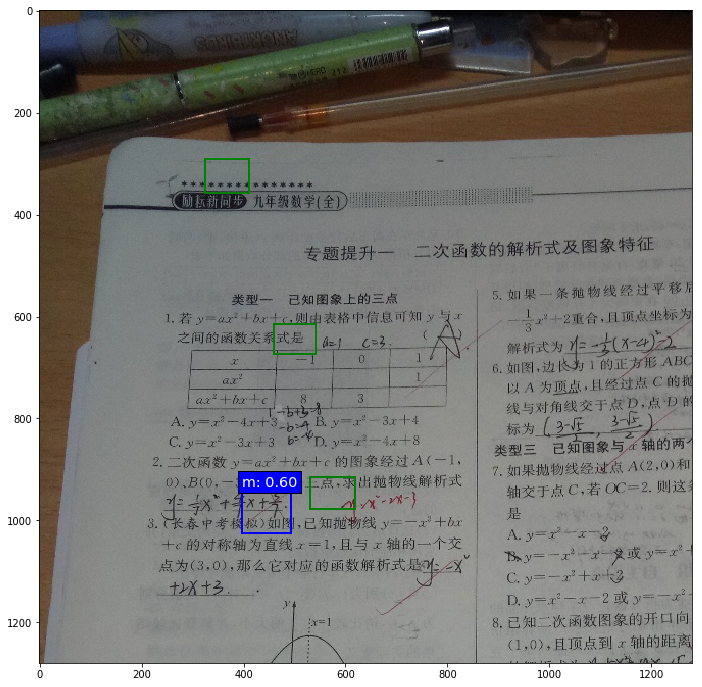

In [159]:
# 5: Draw the predicted boxes onto the image
import cv2

plt.figure(figsize=(20,12))
Xi = X[i] #cv2.cvtColor(X[i], cv2.COLOR_HSV2RGB)
plt.imshow(Xi)

current_axis = plt.gca()

classes = ['background', 'm'] # Just so we can print class names onto the image instead of IDs

# Draw the predicted boxes in blue
for box in y_pred_decoded[i]:
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((box[2], box[4]), box[3]-box[2], box[5]-box[4], color='blue', fill=False, linewidth=2))  
    current_axis.text(box[2], box[4], label, size='x-large', color='white', bbox={'facecolor':'blue', 'alpha':1.0})

# Draw the ground truth boxes in green (omit the label for more clarity)
for box in y_true[i]:
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((box[1], box[3]), box[2]-box[1], box[4]-box[3], color='green', fill=False, linewidth=2))  
    #current_axis.text(box[1], box[3], label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

# evaluate map

In [161]:
# ssd_keras xmin, xmax, ymin, ymax 
# coco xmin, ymin, xmax, ymax
def to_coco(array2):
    if array2.shape[0] == 0:
        return array2
    
    xmin = array2[:, 0]
    xmax = array2[:, 1]
    ymin = array2[:, 2]
    ymax = array2[:, 3]
    return np.stack((xmin, ymin, xmax, ymax), axis=-1)

def extract_patch(X, xmin, xmax, ymin, ymax):
    h, w = X.shape[1:3]
    patches = X[:, ymin:ymax, xmin:xmax, :]
    y = np.zeros(X.shape)
    for i in range(patches.shape[0]):
        y[i] = cv2.resize(patches[i], (h, w))
    return y

def y_pred_patch(y_pred, xmin, xmax, ymin, ymax):
    scale_x = full_img_width / (xmax-xmin)
    scale_y = full_img_height / (ymax-ymin)
    y_pred[:, :, -8] = y_pred[:, :, -8] / scale_x + xmin # cx
    y_pred[:, :, -7] = y_pred[:, :, -7] / scale_y + ymin # cy
    y_pred[:, :, -6] = y_pred[:, :, -6] / scale_x # width
    y_pred[:, :, -5] = y_pred[:, :, -5] / scale_y # height
    return y_pred    
        
from mean_average_precision.detection_map import DetectionMAP
def calculate_map(gen, num_examples, full_model, img_height, img_width):

  mAP = DetectionMAP(2, overlap_threshold= 0.2) # 0.2 will make auc very low
  for i in range(num_examples):
    X, y_true, filenames = next(gen)

    top_left = extract_patch(X, 0, full_img_width//2, 0, full_img_height//2)
    top_right = extract_patch(X, full_img_width//2, full_img_width, 0, full_img_height//2)
    bottom_left = extract_patch(X, 0, full_img_width//2, full_img_height//2, full_img_height)
    bottom_right = extract_patch(X, full_img_width//2, full_img_width, full_img_height//2, full_img_height)
    
    y_pred = full_model.predict(X)
    y_pred_tl = y_pred_patch(full_model.predict(top_left), 0, full_img_width//2, 0, full_img_height//2)
    y_pred_tr = y_pred_patch(full_model.predict(top_right), full_img_width//2, full_img_width, 0, full_img_height//2)
    y_pred_bl = y_pred_patch(full_model.predict(bottom_left), 0, full_img_width//2, full_img_height/2, full_img_height)
    y_pred_br = y_pred_patch(full_model.predict(bottom_right), full_img_width//2, full_img_width, full_img_height//2, full_img_height)
    
    merged = np.concatenate([y_pred, y_pred_tl, y_pred_tr, y_pred_bl, y_pred_br], axis = 1)
    y_pred_decoded = decode_y2(merged,
                           confidence_thresh=0.3,
                          iou_threshold=testing_iou_threshold, # 0.4
                          top_k='all',
                          input_coords='centroids',
                          normalize_coords=False,
                               img_height=None,
                               img_width=None)

    gt_bb = y_true[0][:, 1:] / np.array([img_width, img_width, img_height, img_height])
    if y_pred_decoded and y_pred_decoded[0].shape[0] > 0:
        # print(y_pred_decoded)
        pred_bb = y_pred_decoded[0][:, 2:] / np.array([img_width, img_width, img_height, img_height])
        pred_cls = y_pred_decoded[0][:, 0]
        pred_conf = y_pred_decoded[0][:, 1]
    else:
        pred_bb = np.array([])
        pred_cls = np.array([])
        pred_conf = np.array([])
    pred_bb = to_coco(pred_bb)
    gt_bb = to_coco(gt_bb)
    gt_class = y_true[0][:, 0]
    mAP.evaluate(pred_bb, pred_cls, pred_conf, gt_bb, gt_class)
    #print(pred_bb, pred_cls, pred_conf, gt_bb, gt_class)
  return mAP

mAP = calculate_map(predict_generator, n_val_samples, full_model, full_img_height, full_img_width) # n_val_samples


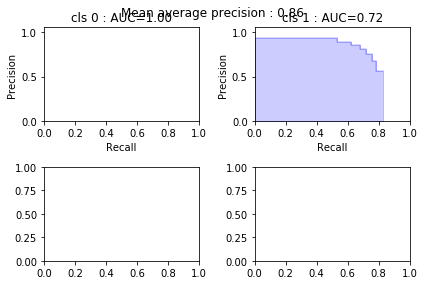

In [162]:
mAP.plot()

In [163]:
print('auc is %s' % mAP.compute_ap(1))

auc is 0.7243427876707609


In [ ]:
# mMP's 
# ssd7_0 auc 0.5, ssd7_1 auc 0.62, ssd7_2 auc 0.63
# ssd7_2 auc 0.65 by reducing iou_threshold=0.3, # 0.4, and min_scale = 0.01
  # if we use DetectionMAP(2, overlap_threshold= 0.2), then auc is 0.38
# ssd7_3 improves to 0.46

# generate bad predictions

In [59]:
from ssd_box_encode_decode_utils import iou, iot
from PIL import Image
# bbox: xmin,xmax,ymin,ymax
def match_bbox(pos_iou_threshold, neg_iot_threshold, ground_truth, predicted_bbox):
    true_positive = []
    false_negative = []
    false_positive = []
    available_boxes = np.ones((predicted_bbox.shape[0])) # 1 for all anchor boxes that are not yet matched to a ground truth box, 0 otherwise
    negative_boxes = np.ones((predicted_bbox.shape[0])) # 1 for all negative boxes, 0 otherwise
    for true_box in ground_truth: # For each ground truth box belonging to the current batch item...
        true_box = true_box.astype(np.float)
        if abs(true_box[1] - true_box[0] < 0.001) or abs(true_box[3] - true_box[2] < 0.001): continue # Protect ourselves against bad ground truth data: boxes with width or height equal to zero
        similarities = iou(predicted_bbox, true_box, coords='minmax') # The iou similarities for all anchor boxes
        similarities_t = iot(predicted_bbox, true_box, coords='minmax')
        negative_boxes[similarities_t >= neg_iot_threshold] = 0 # If a negative box gets an IoU match >= `self.neg_iot_threshold`, it's no longer a valid negative box
        similarities *= available_boxes # Filter out anchor boxes which aren't available anymore (i.e. already matched to a different ground truth box)
        available_and_thresh_met = np.copy(similarities)
        available_and_thresh_met[available_and_thresh_met < pos_iou_threshold] = 0 # Filter out anchor boxes which don't meet the iou threshold
        assign_indices = np.nonzero(available_and_thresh_met)[0] # Get the indices of the left-over anchor boxes to which we want to assign this ground truth box
        if len(assign_indices) > 0: # If we have any matches
            true_positive.append(true_box)
            best_match_index = np.argmax(available_and_thresh_met)
            available_boxes[best_match_index] = 0 # Make the assigned anchor boxes unavailable for the next ground truth box
        else: # If we don't have any matches
            false_negative.append(true_box)
    # Set the classes of all remaining available anchor boxes to class zero
    for index in np.nonzero(negative_boxes)[0]:
        false_positive.append(predicted_bbox[index])
    return true_positive, false_negative, false_positive

result = open('../../data/corrections/set2_testing_positive_negative.xml', 'w')
result.write("""<?xml version='1.0' encoding='ISO-8859-1'?>
<?xml-stylesheet type='text/xsl' href='image_metadata_stylesheet.xsl'?>
<dataset>
<name>imglab dataset</name>
<comment>Created by imglab tool.</comment>
<images>
""")
for i in range(n_val_samples):
    X, y_true, filenames = next(predict_generator)
    y_pred = full_model.predict(X)
    y_pred_decoded = decode_y2(y_pred,
                           confidence_thresh=0.5,
                          iou_threshold=testing_iou_threshold,
                          top_k='all',
                          input_coords='centroids',
                          normalize_coords=False,
                          img_height=full_img_height,
                          img_width=full_img_width)
    if y_pred_decoded[0].shape[0] > 0:
        y_pred_decoded[0][:, 2:4] /= full_img_width
        y_pred_decoded[0][:, 4:6] /= full_img_height
        predicted = y_pred_decoded[0][:, 2:]
    else:
        predicted = np.array([[0.0,0.0,0.0,0.0]])
    y_true[0] = y_true[0].astype(np.float)
    y_true[0][:, 1:3] /= full_img_width
    y_true[0][:, 3:5] /= full_img_height
    #print(y_true[0][:,1:])
    true_positive, false_negative, false_positive = match_bbox(0.2, 0.2, y_true[0][:,1:], predicted)
    if len(false_negative) == 0 and len(false_positive) == 0: continue
        
    img = Image.open(filenames[0], 'r')
    width, height = full_img_width, full_img_height #img.size
    result.write("<image file='%s'>\n" % filenames[0])
    for box in false_negative:
        result.write("  <box top='%s' left='%s' width='%s' height='%s'>\n    <label>neg</label>\n  </box>\n" % 
                     (int(box[2] * height), int(box[0] * width), 
                      int((box[1]-box[0])*width), int((box[3]-box[2])*height)))
    for box in false_positive:
        if box[1] - box[0] > 0.0001:
            result.write("  <box top='%s' left='%s' width='%s' height='%s'>\n    <label>pos</label>\n  </box>\n" % 
                     (int(box[2] * height), int(box[0] * width), 
                      int((box[1]-box[0])*width), int((box[3]-box[2])*height)))
    result.write("</image>\n")
result.write("""
</images>
</dataset>""")
result.close()

In [34]:
a = np.arange(100).reshape((25, 4))
index = np.argmax(a[:, 1:], axis = -2)
a[index, :]

array([[96, 97, 98, 99],
       [96, 97, 98, 99],
       [96, 97, 98, 99]])

In [36]:
np.max(a[:, 1:], axis = -2)

array([97, 98, 99])

In [5]:
import tensorflow as tf
def return_max_nonbackground(x):
    background, forground = tf.split(x, [-1, 1], axis = -1)
    forground = tf.squeeze(forground, axis = -1)
    max_forground = tf.to_int32(tf.argmax(forground, axis = 1))

    b_2 = tf.expand_dims(max_forground, 1)
    r2 = tf.expand_dims(tf.range(tf.shape(max_forground)[0]), 1)
    ind = tf.concat([r2, b_2], 1)
    max_over_boxes = tf.gather_nd(x, ind)

    return max_over_boxes      

In [42]:
sess = tf.Session()
const = np.array([np.arange(784).astype(np.float32), np.arange(784).astype(np.float32)])
c = tf.constant(const)
d = tf.argmax(c, axis = -1)             
#d = return_max_nonbackground(c)

cc = sess.run(d)

In [43]:
cc

array([783, 783])

In [38]:
const2 = tf.reshape(const, (-1, 28, 28))
d = tf.argmax(const2, axis = -1)             
#d = return_max_nonbackground(c)

cc = sess.run(d)

0

In [50]:
A = np.array([np.reshape(np.arange(784).astype(np.float32), (28, 28)), np.reshape(np.arange(784).astype(np.float32), (28, 28))])
(row,col) = np.unravel_index(A.argmax(axis=-1), A.shape[1:])


In [63]:
import numpy as np
import tensorflow as tf

x = np.zeros((10,9,8))
# pick a random position for each batch image that we set to 1
pos = np.stack([np.random.randint(9,size=10), np.random.randint(8,size=10)])

posext = np.concatenate([np.expand_dims([i for i in range(10)], axis=0), pos])
x[tuple(posext)] = 1

a = tf.argmax(tf.reshape(x, [10, -1]), axis=1)
pos2 = tf.stack([a // 8, tf.mod(a, 8)]) # recovered positions, one per batch image


AttributeError: module 'tensorflow' has no attribute 'dstack'

In [55]:
pos

array([[2, 8, 2, 4, 5, 4, 1, 2, 1, 7],
       [2, 1, 7, 7, 4, 6, 1, 6, 3, 7]])

In [56]:
posext

array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [2, 8, 2, 4, 5, 4, 1, 2, 1, 7],
       [2, 1, 7, 7, 4, 6, 1, 6, 3, 7]])

In [58]:
sess.run(pos2)

array([[2, 8, 2, 4, 5, 4, 1, 2, 1, 7],
       [2, 1, 7, 7, 4, 6, 1, 6, 3, 7]])

In [62]:
x[1][8,1]

1.0